In [1]:
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import xarray as xr

import h5py
import cartopy.crs as ccrs
    
from mydedalustools import *    

%load_ext autoreload
%autoreload 2

SNAPSHOTS_DIR = "/pscratch/sd/q/qnicolas/stationarywave_snapshots/"

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


This notebook presents two tests of a 2-level sigma model: A stationary orographic Rossby wave in midlatitudes, and a Gill pattern in the tropics.
Note that the model has strong damping in the lower layer, which affects the Gill pattern quite strongly.

In [2]:
# Simulation units
meter = 1 / 6.37122e6
hour = 1
second = hour / 3600
day = hour*24
Kelvin = 1
kilogram=1.
Pascal = kilogram / meter / second ** 2

# Earth parameters
R0 = 6.4e6*meter
Omega = 2*np.pi/86400 / second
g = 9.81 * meter/second**2
p0 = 1e5 * Pascal

# Topographic Rossby wave

In [3]:
snapshot_id = 'stationarywave_2level_T32_topo'
zonaljet = open_h5s(snapshot_id,('s1',),SNAPSHOTS_DIR=SNAPSHOTS_DIR)
zonaljet = concat_levels(zonaljet ,2)


## Basic-state wind and geopotential, topography

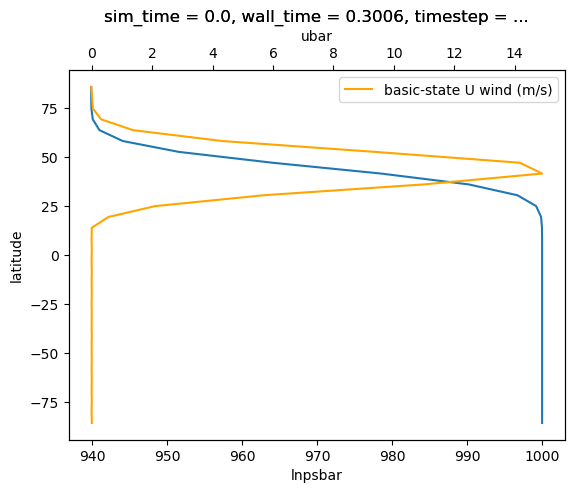

In [4]:
(1e3*np.exp(zonaljet.lnpsbar[0,0])).plot(y='latitude',label='basic-state surface pressure (hPa)')
plt.twiny()
(zonaljet.ubar[0,0,0,:,0]/(meter/second)).plot(y='latitude',color='orange',label='basic-state U wind (m/s)')
plt.legend()

Text(0.5, 1.0, 'Topography (m)')

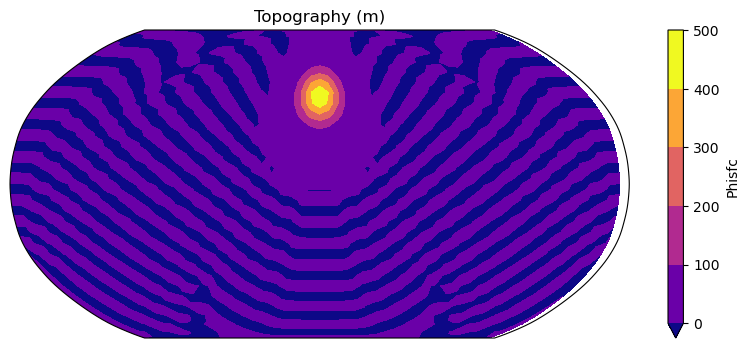

In [5]:
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(zonaljet.Phisfc[0]/g/meter).transpose().plot.contourf(ax=ax,levels=np.arange(0,501,100.),transform=ccrs.PlateCarree(),cmap=plt.cm.plasma)
plt.title('Topography (m)')

## vorticity

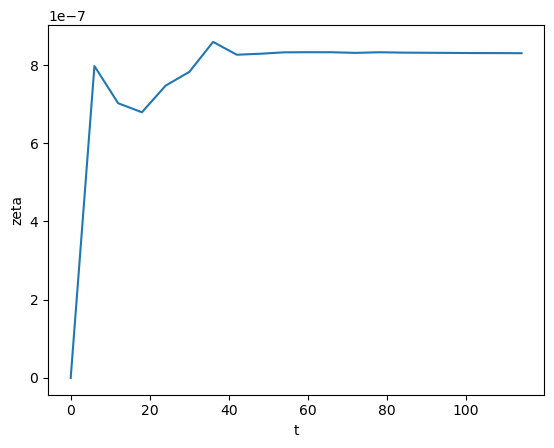

In [6]:
(zonaljet.zeta**2).mean(('longitude','latitude','sigma')).plot()


In [46]:
zonaljet_mean = zonaljet.sel(t=slice(100,None)).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')

def plot_topo(ax):
    topo = (zonaljet.Phisfc[0]/g/meter).transpose()
    topo.plot.contour(ax=ax,levels=[200.],colors='k',transform=ccrs.PlateCarree())

Text(0.5, 1.0, 'Relative vorticity in upper layer (shading) and Topography')

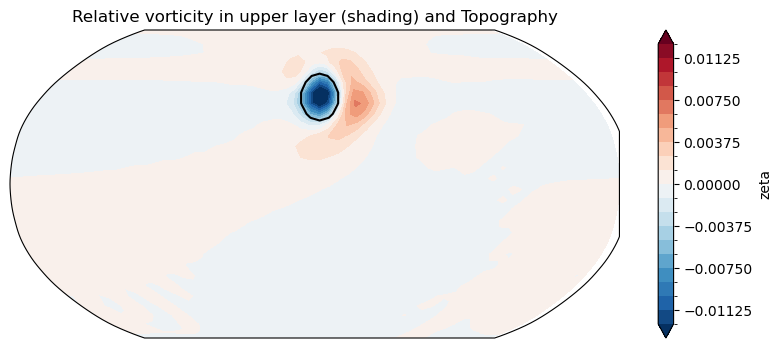

In [47]:
# Perturbation vorticity
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
zonaljet_mean.zeta.isel(sigma=0).plot.contourf(ax=ax,levels=np.linspace(-0.05,0.05,21)/4,extend='both',transform=ccrs.PlateCarree())
plot_topo(ax)
plt.title('Relative vorticity in upper layer (shading) and Topography')

Text(0.5, 1.0, 'Perturbation surface pressure and upper-layer wind ')

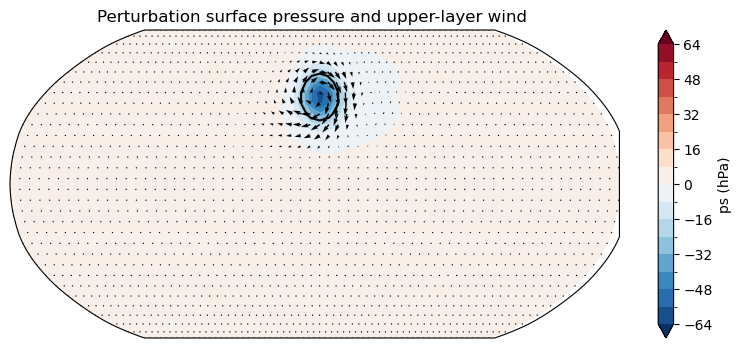

In [51]:
# Perturbation pressure (~p0 * lnps)
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(1e3*zonaljet_mean.lnps).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'ps (hPa)'})

plot_topo(ax)

u= (zonaljet_mean.u[0].isel(sigma=0))
v=-(zonaljet_mean.u[1].isel(sigma=0))
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",scale=5e-2,transform=ccrs.PlateCarree())

plt.title('Perturbation surface pressure and upper-layer wind ')

# Gill pattern

In [88]:
snapshot_id = 'stationarywave_2level_T32_gill'
gill = open_h5s(snapshot_id,('s1',),SNAPSHOTS_DIR=SNAPSHOTS_DIR)
gill = concat_levels(gill ,2)


## Heating pattern

Text(0.5, 1.0, 'Heating in upper layer (K/day)')

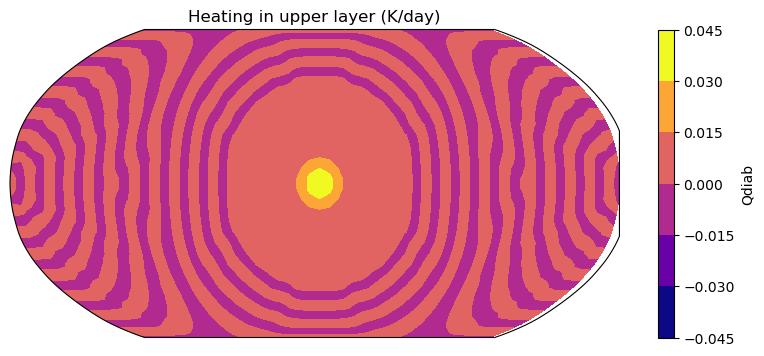

In [89]:
# Perturbation vorticity in rhs run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(gill.Qdiab.isel(t=0,sigma=0)/(Kelvin/day)).transpose().plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap=plt.cm.plasma)
plt.title('Heating in upper layer (K/day)')

## Response

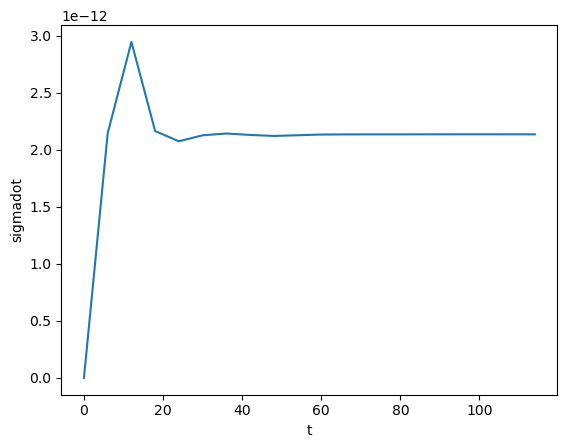

In [90]:
# CONVERGENCE
(gill.sigmadot**2).mean(('longitude','latitude','sigma_stag')).plot()


In [95]:
1060*12/20/3600

0.17666666666666667

In [91]:
gill_mean = gill.sel(t=slice(100,None)).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')
def plot_heating(ax):
    (gill.Qdiab.isel(t=0,sigma=0)/(Kelvin/day)).plot.contour(ax=ax,levels=[0.02],colors='k',transform=ccrs.PlateCarree())

Text(0.5, 1.0, 'Perturbation vorticity in upper layer (s^-1)')

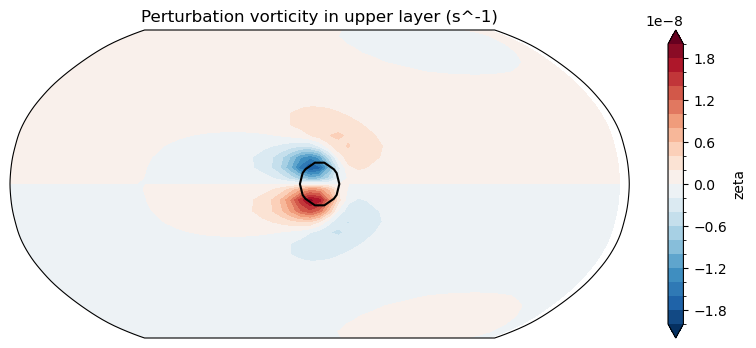

In [92]:
# Perturbation vorticity
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(gill_mean.zeta.isel(sigma=0) * second).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
plot_heating(ax)
plt.title('Perturbation vorticity in upper layer (s^-1)')

Text(0.5, 1.0, 'Perturbation surface pressure and upper-layer wind ')

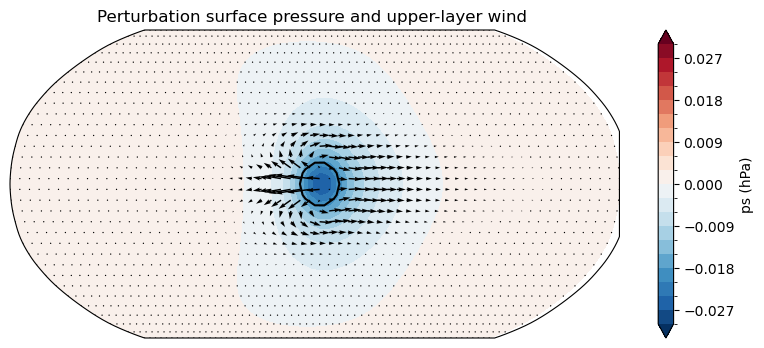

In [93]:
# Perturbation pressure (~p0 * lnps)
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(1e3*gill_mean.lnps).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'ps (hPa)'})

plot_heating(ax)

u= (gill_mean.u[0].isel(sigma=0))
v=-(gill_mean.u[1].isel(sigma=0))
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",scale=2e-4,transform=ccrs.PlateCarree())

plt.title('Perturbation surface pressure and upper-layer wind ')

Text(0.5, 1.0, 'Perturbation pressure velocity (not sigma_dot) and upper-layer wind ')

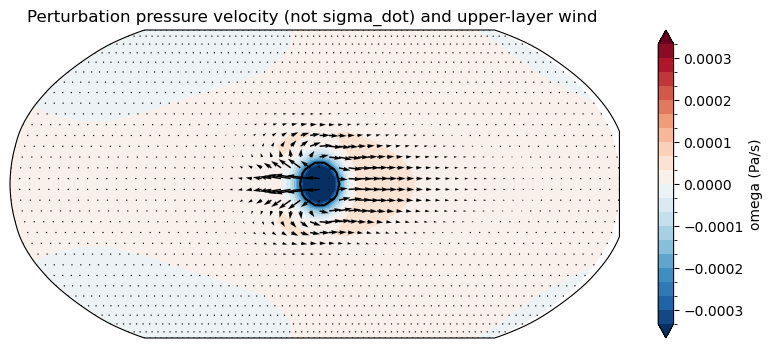

In [94]:
# Perturbation pressure (~p0 * lnps)
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})

(gill_mean.omega.isel(sigma_stag=0)/(Pascal/second)).plot.contourf(ax=ax,levels=np.linspace(-1,1,21)/3e3,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'omega (Pa/s)'})

plot_heating(ax)

u= (gill_mean.u[0].isel(sigma=0))
v=-(gill_mean.u[1].isel(sigma=0))
n=1;m=n
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",scale=2e-4,transform=ccrs.PlateCarree())

plt.title('Perturbation pressure velocity (not sigma_dot) and upper-layer wind ')